In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from model import model
from DataExtraction import utils
import os
import ujson

In [107]:
# Load, from each model, the results, the model configuration and the evaluation metrics
os.chdir(utils.get_root_dir() + '/model/final_models')
n_models = len([name for name in os.listdir('.') if 'model_' in name])
training_stats, testing_stats, model_results, model_info = {}, {}, {}, {}
for i in range(1, n_models + 1):
    print(f'Loading model {i}')
    m = model.load_model(f'model_{i}')
    model_info[m.model_config.model_name] = m.model_config.__dict__
    with open(m.model_config.model_src + '/train/training_stats.json', 'r') as f:
        training_stats[m.model_config.model_name] = ujson.load(f)
    with open(m.model_config.model_src + '/test/losses.json', 'r') as f:
        testing_stats[m.model_config.model_name] = ujson.load(f)
    model_results[m.model_config.model_name] = np.load(m.model_config.model_src + '/test/y_pred.npy'), np.load(m.model_config.model_src + '/test/y_test.npy')
    del m

Loading model 1
Model model_1 created
Loading model 2
Model model_2 created
Loading model 3
Model model_3 created
Loading model 4
Model model_4 created
Loading model 5
Model model_5 created
Loading model 6
Model model_6 created
Loading model 7
Model model_7 created
Loading model 8
Model model_8 created
Loading model 9
Model model_9 created
Loading model 10
Model model_10 created
Loading model 11
Model model_11 created
Loading model 12
Model model_12 created
Loading model 13
Model model_13 created
Loading model 14
Model model_14 created
Loading model 15
Model model_15 created
Loading model 16
Model model_16 created
Loading model 17
Model model_17 created
Loading model 18
Model model_18 created
Loading model 19
Model model_19 created
Loading model 20
Model model_20 created
Loading model 21
Model model_21 created
Loading model 22
Model model_22 created
Loading model 23
Model model_23 created
Loading model 24
Model model_24 created
Loading model 25
Model model_25 created
Loading model 26
M

In [108]:
def get_model_information(model_name, training_stats, testing_stats, model_results, model_info, results_df):
    model_type = model_info['model_type']
    temporal_window = model_info['window_size'] if model_type == 'LSTM' else str(model_info['window_size']) + '/' + str(model_info['subwindow_size'])
    training_time = sum(training_stats['epoch_times'])
    # num_params = sum(model_info['num_parameters'])
    epoch_num = max(training_stats['epoch_num'])
    layers_blocks = model_info['num_layers'] if model_type == 'LSTM' else model_info['xLSTM_config'].num_blocks
    batch_size = model_info['batch_size']
    dropout = model_info['dropout']
    learning_rate = model_info['lr']
    mse = testing_stats['total']['mse']
    mae = testing_stats['total']['mae']
    rmse = testing_stats['total']['rmse']
    r2 = testing_stats['total']['r2']
    results_df[model_name] = {
        'Type': model_type,
        'Temporal Window': temporal_window,
        'Training Time': training_time,
        # 'Number of Parameters': num_params,
        'Number of Epochs': epoch_num,
        'Layers/Blocks': layers_blocks,
        'Batch Size': batch_size,
        'Dropout': dropout,
        'Learning Rate': learning_rate,
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2
    }

In [109]:
final_df = pd.DataFrame(index=['Type', 'Temporal Window', 'Training Time', 'Number of Epochs', 'Layers/Blocks', 'Batch Size', 'Dropout', 'Learning Rate', 'MSE', 'MAE', 'RMSE', 'R2'])

In [110]:
for model_name in model_info.keys():
    get_model_information(model_name, training_stats[model_name], testing_stats[model_name], model_results[model_name], model_info[model_name], final_df)

In [111]:
final_df

,model_1,model_2,model_3,model_4,model_5,model_6,model_7,model_8,model_9,model_10,...,model_19,model_20,model_21,model_22,model_23,model_24,model_25,model_26,model_27,model_28
Type,LSTM,LSTM,LSTM,LSTM,LSTM,LSTM,LSTM,LSTM,xLSTM,xLSTM,...,LSTM,LSTM,xLSTM,xLSTM,xLSTM,xLSTM,xLSTM,xLSTM,xLSTM,xLSTM
Temporal Window,None,None,None,None,None,None,None,270,None/None,None/None,...,None,None,None/None,None/None,None/None,None/None,None/None,None/None,None/None,None/None
Training Time,2132.929452,2137.663442,2094.973156,2047.336608,2631.627446,2638.274787,2575.797658,2811.845595,5900.423708,5878.499905,...,2421.931086,2361.224301,6210.207793,6338.70629,6094.216024,5939.041857,4564.741714,4524.463153,4513.906068,4506.969256
Number of Epochs,200,200,200,200,350,350,350,350,200,200,...,300,300,250,250,250,250,350,350,350,350
Layers/Blocks,5,5,5,5,3,3,3,3,5,5,...,10,10,7,7,7,7,3,3,3,3
Batch Size,24,24,24,24,64,64,64,64,32,32,...,32,32,128,128,128,128,64,64,64,64
Dropout,0.2,0.2,0.2,0.2,0.3,0.3,0.3,0.3,0.2,0.2,...,0.25,0.25,0.3,0.3,0.3,0.3,0.2,0.2,0.2,0.2
Learning Rate,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,0.00001,...,0.0001,0.0001,0.0001,0.0001,0.0001,0.0001,0.00001,0.00001,0.00001,0.00001
MSE,0.039331,0.042765,0.084506,0.151322,0.019271,0.060586,0.048653,0.140879,0.033646,0.057049,...,0.134503,0.137961,0.035675,0.035836,0.147557,0.12494,0.020773,0.044988,0.077863,0.149325
MAE,0.143567,0.161574,0.237904,0.317241,0.099551,0.19361,0.178644,0.29853,0.143079,0.18396,...,0.318364,0.321269,0.156527,0.146466,0.317156,0.302242,0.111163,0.16778,0.225021,0.306068


In [112]:
def plot_results_in_same_chart(y_pred, y_test, title="", colors = None, models = None):
    n_results = len(y_pred)
    plt.figure(figsize=(16, 9))
    # If predictions are not of the same length, we will plot only the last n_results
    min_len = min([len(y) for y in y_pred])
    y_pred = [y[-min_len:] for y in y_pred]
    for i in range(n_results):
        c = colors[i] if colors is not None else None
        label = models[i] if models is not None else None
        plt.plot(y_pred[i], label=label, color=c)
    plt.plot(y_test, label='True', linestyle='--', color='black')
    plt.legend()
    plt.title(title)
    plt.show()

In [113]:
# MODEL CLASSIFICATION
# By Model Number
m1 = {'model_1': 30, 'model_2': 90, 'model_3': 180, 'model_4': 365}
m2 = {'model_5': 30, 'model_6': 90, 'model_7': 180, 'model_8': 365}
m3 = {'model_9': 30, 'model_10': 90, 'model_11': 180, 'model_12': 365}
m4 = {'model_13': 30, 'model_14': 90, 'model_15': 180, 'model_16': 365}
m5 = {'model_17': 30, 'model_18': 90, 'model_19': 180, 'model_20': 365}
m6 = {'model_21': 30, 'model_22': 90, 'model_23': 180, 'model_24': 365}
m7 = {'model_25': 30, 'model_26': 90, 'model_27': 180, 'model_28': 365}
all_models_by_number = {f'Model {[m1, m2, m3, m4, m5, m6, m7].index(m)+1}': m for m in [m1, m2, m3, m4, m5, m6, m7]}
# By Steps Forward
sfw_30 = ['model_1', 'model_5', 'model_9', 'model_13', 'model_17', 'model_21', 'model_25']
sfw_90 = ['model_2', 'model_6', 'model_10', 'model_14', 'model_18', 'model_22', 'model_26']
sfw_180 = ['model_3', 'model_7', 'model_11', 'model_15', 'model_19', 'model_23', 'model_27']
sfw_365 = ['model_4', 'model_8', 'model_12', 'model_16', 'model_20', 'model_24', 'model_28']
all_models_by_sfw = [sfw_30, sfw_90, sfw_180, sfw_365]
possible_models = [f'Model {i}' for i in range(1, 8)]

In [114]:
def get_pred(model_name, model_results, sensor):
    return model_results[model_name][0].T[sensor]
def get_test(model_results, sensor):
    return model_results['model_1'][1].T[sensor]

In [115]:
def plot_same_sfw_predictions(sensor, model_results, models):
    y_pred = [get_pred(model, model_results, sensor) for model in models]
    y_test = get_test(model_results, sensor)
    # Min prediction length
    min_len = min([len(y) for y in y_pred])
    y_pred = [y[-min_len:] for y in y_pred]
    # Plot results
    model_corrected_number = []
    for model in models:
        for i in possible_models:
            if model in all_models_by_number[i]:
                model_corrected_number.append(i)
                break
    plot_results_in_same_chart(y_pred, y_test, title=f'{sensor} days ahead prediction', models=model_corrected_number)

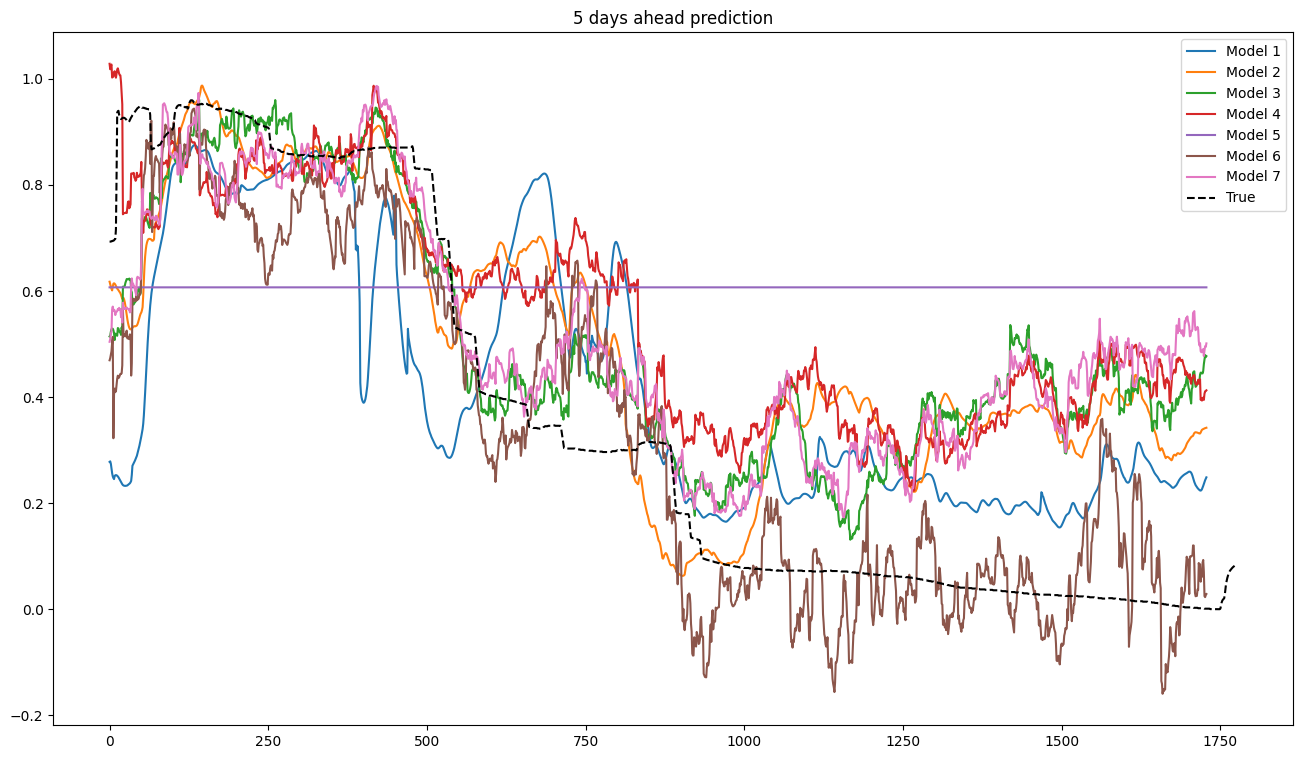

In [116]:
# 30 days ahead prediction
plot_same_sfw_predictions(5, model_results, sfw_90)